In [2033]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
def css_styling():
    styles = """
<style>
.output_png { text-align:  center; }
</style>
    """
    return HTML(styles)
css_styling()

import matplotlib

# Jak wygrać konkursy 2

# 1. Bagging - Uzupełnienie

## Ważenie podczas głosowania/uśredniania

* W Bagging, losujemy $m$ przykładów z **powtorzeniami**.
* Prawie 40% danych nie jest wykorzystywanych, ponieważ $\lim_{n \rightarrow \infty}\left(1-\frac{1}{n}\right)^n = e^{-1} \approx 0.368 $.
* Możemy te dany wykorzystać jako **zestaw walidacyjny** i obliczyć **na nim** błąd $J_w(\theta)$.
* Wtedy gdy mamy $N$ klasyfikatorów, dla $i$-tego klasyfikatora obliczamy $w_i$ (dlaczego $-J$?):

$$ w_i = \dfrac{\exp(-J_w(\theta_i))}{
\sum_{j=1}^N \exp(-J_w(\theta_j))} $$


* Klasyfikacja przez ważone głosowanie (zbiór klas $C$, $y_i$ to odpowiedź $i$-tego klasyfikatora):
$$y = \mathop{\mathrm{argmax}}_{c \in C} \sum_{i=1}^N w_i  I(c = y_i) $$
gdzie 
$$I(A) = \left\{\begin{array}{cl}1 & \textrm{gdy zachodzi zdarzenie A}\\ 0 & \textrm{wpp.}\end{array}\right.$$


* Klasyfikacja przez obliczenie ważonych średnich prawdopodobieństw (zbiór klas $C$, $y_i$ to odpowiedź $i$-tego klasyfikatora):
$$y = \mathop{\mathrm{argmax}}_{c \in C} \dfrac{w_ip_{c,i}}{\sum_{j=1}^{N} w_j p_{c,j}} $$
gdzie $p_{c,i}$ jest prawdopodobieństwem wyboru klasy $c$ przez $i$-ty klasyfikator.


## Ważony bagging na MNIST

Do samodzielnego sprawdzenia w ramach zadań bonusowych na ćwiczeniach (20 pkt.).

# 2. Zjawisko nadmiernego dopasowania i regularyzacja

In [2067]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def powerme(x1,x2,n):
    X = []
    for m in range(n+1):
        for i in range(m+1):
            X.append(np.multiply(np.power(x1,i),np.power(x2,(m-i))))
    return np.hstack(X)

def safeSigmoid(x, eps=0):
    y = 1.0/(1.0 + np.exp(-x))
    # przytnij od dolu i gory
    if eps > 0:
        y[y < eps] = eps
        y[y > 1 - eps] = 1 - eps
    return y

def h(theta, X, eps=0.0):
    return safeSigmoid(X*theta, eps)

def J(h,theta,X,y, lamb=0):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    j = -np.sum(np.multiply(y, np.log(f)) + 
                np.multiply(1 - y, np.log(1 - f)), axis=0)/m# \
                #+ lamb/(2*m) * np.sum(np.power(theta[1:],2))
    return j

def dJ(h,theta,X,y,lamb=0):
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    #g[1:] += lamb/float(y.shape[0]) * theta[1:] 
    return g

def SGD(h, fJ, fdJ, theta, X, Y, 
        alpha=0.001, maxEpochs=1.0, batchSize=100, 
        adaGrad=False, logError=True, validate=0.0, valStep=100, lamb=0):
    errorsX, errorsY = [], []
    errorsVX, errorsVY = [], []
    
    XT, YT = X, Y
    if validate > 0:
        mv = int(X.shape[0] * validate)
        XV, YV = X[:mv], Y[:mv] 
        XT, YT = X[mv:], Y[mv:] 
    m, n = XT.shape

    start, end = 0, batchSize
    maxSteps = (m * float(maxEpochs)) / batchSize
    
    if adaGrad:
        hgrad = np.matrix(np.zeros(n)).reshape(n,1)
    
    for i in range(int(maxSteps)):
        XBatch, YBatch =  XT[start:end,:], YT[start:end,:]

        grad = fdJ(h, theta, XBatch, YBatch, lamb=lamb)
        if adaGrad:
            hgrad += np.multiply(grad, grad)
            Gt = 1.0 / (10**-7 + np.sqrt(hgrad))
            theta = theta - np.multiply(alpha * Gt, grad)
        else:
            theta = theta - alpha * grad
        
        if logError:
            errorsX.append(float(i*batchSize)/m)
            errorsY.append(fJ(h, theta, XBatch, YBatch).item())
            if validate > 0 and i % valStep == 0:
                errorsVX.append(float(i*batchSize)/m)
                errorsVY.append(fJ(h, theta, XV, YV).item())
        
        if start + batchSize < m:
            start += batchSize
        else:
            start = 0
        end = min(start + batchSize, m)
    return theta, (errorsX, errorsY, errorsVX, errorsVY)

def classifyBi(theta, X):
    prob = h(theta, X)
    return prob

In [2068]:
n = 6
sgd = True

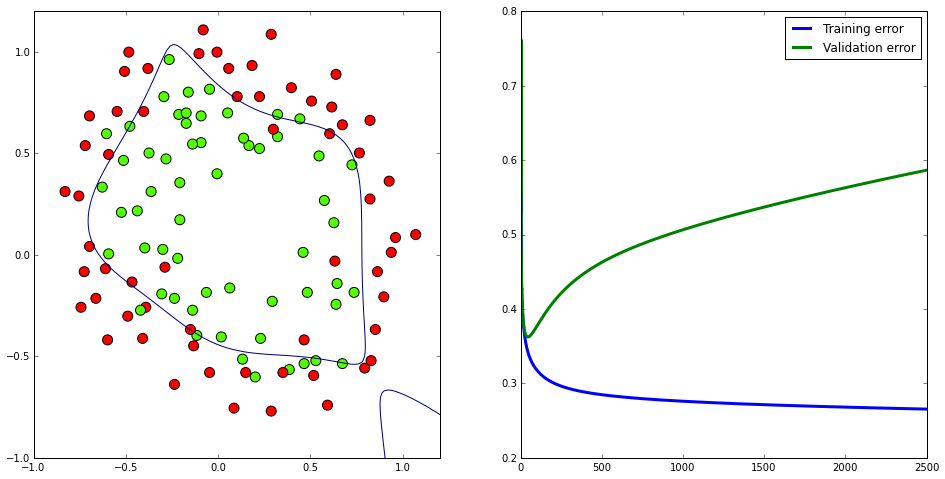

In [2069]:
data = np.matrix(np.loadtxt("ex2data2.txt",delimiter=","))
np.random.shuffle(data)

X = powerme(data[:,0], data[:,1],n)
Y = data[:,2]

pyplot.figure(figsize=(16,8))
pyplot.subplot(121)
pyplot.scatter(X[:,2].tolist(),
               X[:,1].tolist(),
               c=Y.tolist(),
               s=100, cmap=pyplot.cm.get_cmap('prism'));

if sgd:
    theta = np.matrix(np.zeros(X.shape[1])).reshape(X.shape[1],1)
    thetaBest, err = SGD(h, J, dJ, theta, X, Y, alpha=1, adaGrad=True, maxEpochs=2500, batchSize=100, 
                         logError=True, validate=0.25, valStep=1, lamb=0)

    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.02),
                         np.arange(-1.5, 1.5, 0.02))
    l = len(xx.ravel())
    C = powerme(xx.reshape(l,1),yy.reshape(l,1),n)
    z = classifyBi(thetaBest, C).reshape(np.sqrt(l),np.sqrt(l))

    pyplot.contour(xx, yy, z, levels=[0.5], lw=3);
    pyplot.ylim(-1,1.2);
    pyplot.xlim(-1,1.2);
    pyplot.legend();
    pyplot.subplot(122)
    pyplot.plot(err[0],err[1], lw=3, label="Training error")
    pyplot.plot(err[2],err[3], lw=3, label="Validation error");
    pyplot.legend()
    pyplot.ylim(0.2,0.8);

## Regularyzacja 

* Metoda zapobiegania zjawiskom nadmiernego dopasowania (*overfitting*)
* Kara za ekstremalne wartości parametrów $\theta$
* Najbardziej popularne metody to $L_1$ i $L_2$ ($L_p = ||x||^p_p = \sum_{i=0}^n |x_i|^p$)
* $L_1$ nie jest różniczkowalna, w metodach opartach na gradientach stosuje się raczej $L_2$.

## Regularyzacja dla regresji logistycznej

* Funkcja kosztu

$$\small
\begin{array}{rl}
J(\theta)=&-\dfrac{1}{m} [\sum_{i=1}^{m} y^{(i)} \log h_\theta(x^{(i)})+ (1-y^{(i)}) \log (1-h_\theta(x^{(i)}))]\\  &\color{red}{+ \dfrac{\lambda}{2m}\sum_{j=1}^{n}\theta^2_j}
\end{array}
$$

* Gradient

$$\small
\begin{array}{llll}
\dfrac{\partial J(\theta)}{\partial \theta_0} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_0 & \textrm{gdy $j = 0$ }\\
\dfrac{\partial J(\theta)}{\partial \theta_j} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_j \color{red}{+ \dfrac{\lambda}{m}\theta_j} & \textrm{gdy $j \ge 1 $} \\
\end{array} 
$$

## Implementacja

In [2114]:
def J(h,theta,X,y,lamb=0):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    j = -np.sum(np.multiply(y, np.log(f)) + 
                np.multiply(1 - y, np.log(1 - f)), axis=0)/m \
                + lamb/(2*m) * np.sum(np.power(theta[1:] ,2))
    return j

def dJ(h,theta,X,y,lamb=0):
    m = float(y.shape[0])
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    g[1:] += lamb/m * theta[1:]
    return g

In [2115]:
n = 6
lam = 0.01

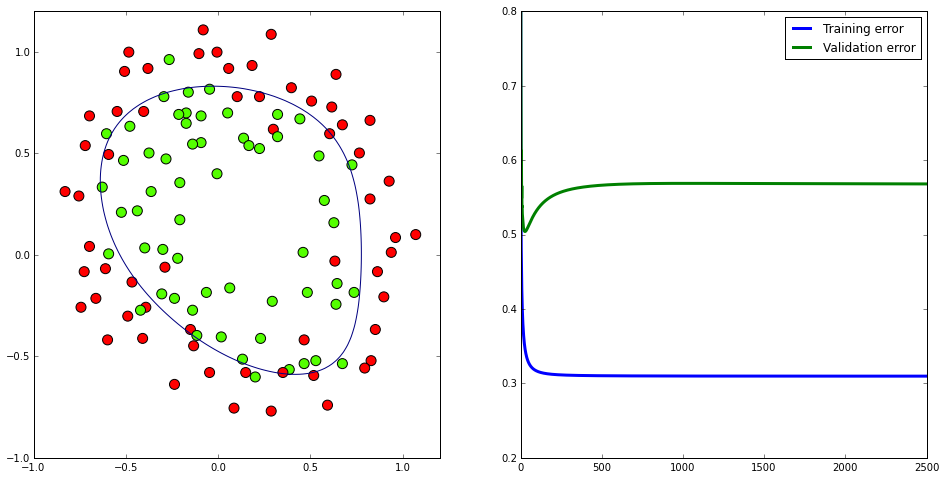

In [2116]:
data = np.matrix(np.loadtxt("ex2data2.txt",delimiter=","))
np.random.shuffle(data)

X = powerme(data[:,0], data[:,1],n)
Y = data[:,2]

theta = np.matrix(np.zeros(X.shape[1])).reshape(X.shape[1],1)
thetaBest, err = SGD(h, J, dJ, theta, X, Y, alpha=1, adaGrad=True, maxEpochs=2500, batchSize=100, 
                     logError=True, validate=0.25, valStep=1, lamb=lam)

xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.02),
                     np.arange(-1.5, 1.5, 0.02))
l = len(xx.ravel())
C = powerme(xx.reshape(l,1),yy.reshape(l,1),n)
z = classifyBi(thetaBest, C).reshape(np.sqrt(l),np.sqrt(l))


pyplot.figure(figsize=(16,8))
pyplot.subplot(121)
pyplot.scatter(X[:,2].tolist(),
               X[:,1].tolist(),
               c=Y.tolist(),
               s=100, cmap=pyplot.cm.get_cmap('prism'));
pyplot.contour(xx, yy, z, levels=[0.5], lw=3);
pyplot.ylim(-1,1.2);
pyplot.xlim(-1,1.2);
pyplot.legend();
pyplot.subplot(122)
pyplot.plot(err[0],err[1], lw=3, label="Training error")
pyplot.plot(err[2],err[3], lw=3, label="Validation error");
pyplot.legend()
pyplot.ylim(0.2,0.8);

## Różne twarze (nie)dopasowania

<img style="margin:auto" width="90%" src="fit.png"/>

## Bias and Variance

* **Bias** (błąd systematyczny): 
    * Błąd wynikający z błędnych założeń co do algorytmu uczącego się. 
    * Duży błąd systematyczny powoduje brak dopasowania.

* **Variance** (wariancja):
    * Błąd wynikający z nadwrażliwości na małe fluktuacje w zestawie uczącym. 
    * Wysoka wariancja może spowodować nadmierne dopasowanie (modelująć szum a nie sygnał).

<img style="margin:auto" width="60%" src="bias2.png"/>

<img style="margin:auto" width="60%" src="curves.jpg"/>

## Poznaliśmy już inne sposoby (niż regularyzacja) na błędy bias i variance?

* Jaki jest efekt zwiększenia liczby cech?
* Wczesne przerwanie trenowania na podstawie obserwacji blędu na danych walidujących (**early stopping**) chroni przed "bias" czy "variance"?
* Metody walidacji, szczególnie walidacji krzyżowej chronią przed "bias" czy "variance"?
* Metody ensemble chronią przed "bias" czy "variance"?

# 3. Urozmaicenie metod

* W metodach Ensemble stwierdziliśmy, że różnorodność pomaga (*bootstrapping*)
* Warto zatem sprawdzić kombinacje zupełnie różnych metod (mówiliśmy głównie o metodach parametrycznych)
* Poznaliśmy już naiwne klasyfikatory Bayesa (inna metoda nieparametryczna)
* Jako kolejną metodę nieparametryczną, warto omówić metodę $k$-najbliższych sąsiadów

# Metoda $k$-najbliższych sąsiadów
<img style="margin-left: auto; margin-right: auto" width="50%" src="https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg"/>
* *ang.* **$k$-nearest-neighbours ($k$-NN)** algorithm/method

## Zarys metody
* Zestaw uczący przechowujemy w całości.
* Dla przykładu testowego liczymy odległośc do wszystkich przykładów w zbiorze uczącym.
* Wybieramy $k$ elementów o najmniejszej odległości ($k$ najbliższych sąsiadów!).
* Akumulujemy wyniki ze zbioru $k$ sąsiadów.
* **Uwaga: Metoda kNN jest bardzo wrażliwa na różnice wielkości cech. Trzeba normalizować.**
     
**Dyskusja:**
* Jest to metoda klasyfikacji czy regresji?
* Jakie są oczywiste wady i zalety (MNIST)?

## Dobór $k$

* Czynnik wygładzający, im większe, tym więcej sasiadów bierze udział w głosowaniu/średniej. 

**Dyskusja**:
* Jakie wartości może przyjąć $k$?
* Jakie wartości wydają się sensowne?
* W jaki sposób dobieramy $k$?


In [2185]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot

def h(theta, X):
    return X.dot(theta)

def norm(X,Y):
    return np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)

def rho(a,b):
    return np.sqrt((a-b)**2)

def kneighbors(k, t, x, y):
    d = rho(t, x)
    nn = np.argsort(d)[:k]
    return y[nn]

def Gauss(x,t,l=.01):
    t = rho(x,t)/l
    return 1./np.sqrt(2*np.pi)*np.exp(-1./2.*t**2)

def Kernel(K,t,x,y,l=.01):
    return np.array([np.sum(K(x,t1,l)*y)/np.sum(K(x,t1,l), axis=1) for t1 in t])

def J(Yp,Y):
    return np.sqrt(1.0/(2*len(y))*(Yp-Y).dot(Yp-Y))

def true(x):
    return 2*x*np.sin(4*x)

m = 300
x = np.linspace(0, 5, m)
ytrue = true(x)
y = ytrue + 3*np.random.randn(m)

t = np.linspace(0, 5, m)
ttrue = true(t)

## Regresja liniowa (wielomianowa)

In [2186]:
n = 11 #stopień wielomianu
show1 = True

RMSE:  1.46550087094


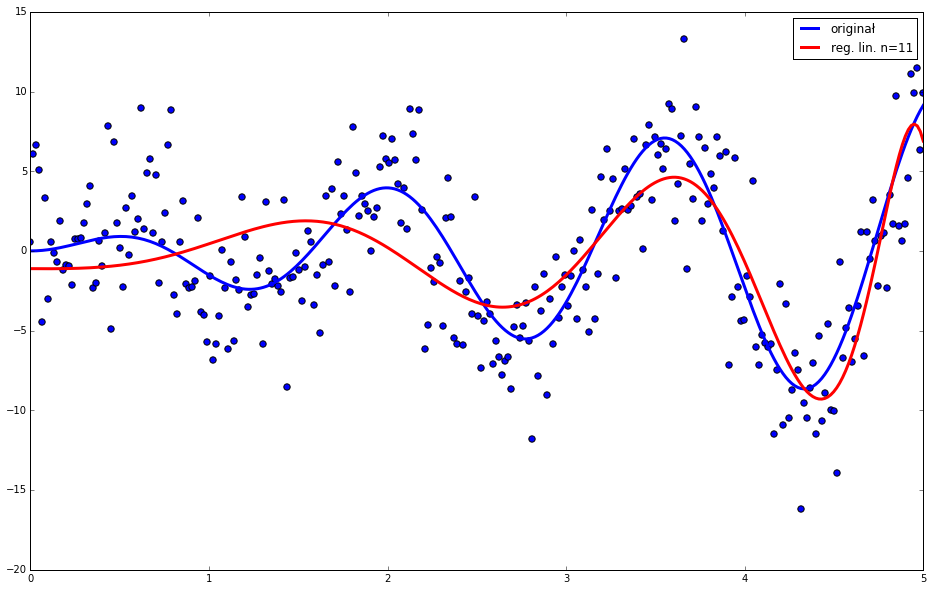

In [2187]:
xtuple = [x**i for i in range(n+1)]
xreg = np.vstack(xtuple).T
theta = norm(xreg,y)

ttuple = [t**i for i in range(n+1)]
treg = np.vstack(ttuple).T

pyplot.figure(figsize=(16,10))
if show1:
    pyplot.plot(x, ytrue, label="originał", lw=3)
pyplot.scatter(x,y, s=40)

if n > 0:
    predict = h(theta, treg)
    pyplot.plot(t, predict, label="reg. lin. n=" + str(n), lw=3, color="red")
    print("RMSE: ", J(predict,ttrue))
pyplot.xlim(0,5)
pyplot.legend();

## Regresja za pomocą k-NN

In [2188]:
k = 16
show2 = True

RMSE:  0.763850185435


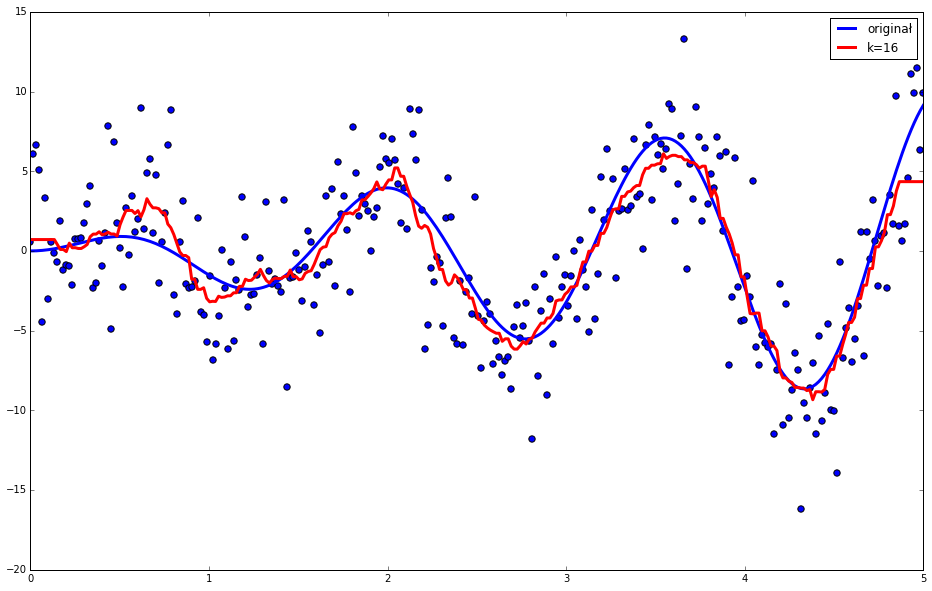

In [2189]:
pyplot.figure(figsize=(16,10))
if show2:
    pyplot.plot(x, ytrue, label="originał", lw=3)
pyplot.scatter(x,y, s=40)
if k > 0:
    predict = np.array([np.mean(kneighbors(k, i, x, y)) for i in t])
    #predict = Kernel(D1,t,x,y,0.1)
    pyplot.plot(t, predict, label="k="+str(k), lw=3, color="red")
    print("RMSE: ", J(predict,ttrue))
pyplot.xlim(0,5)
pyplot.legend();

## Regresja: Ceny mieszkań w Poznaniu

Do samodzielnego sprawdzenia w ramach zadań bonusowych na ćwiczeniach (20 pkt.)

# Klasyfikacja kNN

In [2174]:
k = 16

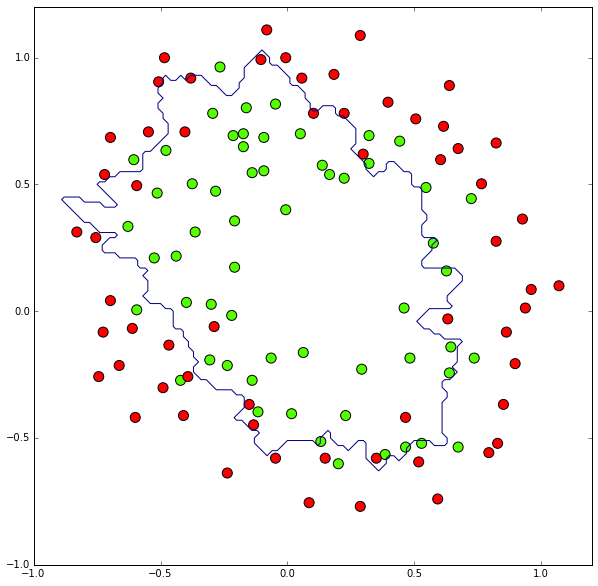

In [2175]:
data = np.matrix(np.loadtxt("ex2data2.txt",delimiter=","))
#np.random.shuffle(data)

n = 1

X = powerme(data[:,0], data[:,1],n)
Y = data[:,2]

def rho(a,b):
    p = np.sqrt(np.sum(np.power((a-b),2), axis=1))
    return p

def kneighbors(k, t, x, y):
    d = rho(t, x)
    nn = np.argsort(d.ravel()).ravel()[0,:k]
    return np.array(y[nn]).reshape(k,).astype(int)

xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.02),
                     np.arange(-1.5, 1.5, 0.02))
l = len(xx.ravel())
C = powerme(xx.reshape(l,1),yy.reshape(l,1),n)

Z = [np.argmax(np.bincount(kneighbors(k,c,X,Y))) for c in C]

pyplot.figure(figsize=(10,10))
pyplot.scatter(X[:,2].tolist(),
               X[:,1].tolist(),
               c=Y.tolist(),
               s=100, cmap=pyplot.cm.get_cmap('prism'));
pyplot.contour(xx, yy, np.array(Z).reshape(np.sqrt(l),np.sqrt(l)), levels=[0.5], lw=3);
pyplot.ylim(-1,1.2);
pyplot.xlim(-1,1.2);

## Klasyfikacja: MNIST

Do samodzielnego sprawdzenia w ramach zadań bonusowych na ćwiczeniach (20 pkt.)

## Miary odległości

* Odległość euklidesowa: $$\rho_1(x,x^{\prime}) = \sqrt{\sum_{i=1}^n \left(x_i - x_i^{\prime}\right)^2}$$
* Ważona odległość euklidesowa (skąd wziąć wagi?): $$\rho_2(x,x^{\prime}) = \sqrt{\sum_{i=1}^n \dfrac{1}{w_i^2}\left(x_i - x_i^{\prime}\right)^2}$$
* Wiele innych ...

**Dyskusja**
* Co robimy w przypadku cech nienumerycznych?

## Uczenie metryk

* Wikipedia: [Large margin nearest neighbor](https://en.wikipedia.org/wiki/Large_margin_nearest_neighbor)
* Trenujemy macierz $M$ (gdy $M=I$, to $\rho$ odległość euklidesowa):
$$ \rho(x, x^{\prime}) = \left((x - x^{\prime})^{T} M (x - x^{\prime})\right)^{\frac{1}{2}} $$

<img style="margin-left:auto; margin-right:auto" width="70%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Lmnn.png/1920px-Lmnn.png"/>

## Ważenie sasiądów według odległości

<img style="margin-left: auto; margin-right: auto" width="50%" src="https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg"/>

* Rozpatrzmy większy okrąg (kreskowany). Czy faktycznie powinniśmy wybrać klasę niebieską?

Dla zbioru $K(x) = \{ (x^{(1)},y^{(1)}), \dots, (x^{(k)},y^{(k)}) \}$ zawierającym $k$ najbliższych sąsiadów $x$ obliczamy: 

* Wagi (widzieliśmy to już gdzieś?):
$$ W(x, x^{(i)}) = \dfrac{\exp(-\rho(x,x^{(i)}))}{
\sum_{j=1}^k \exp(-\rho(x,x^{(j)}))} $$

* Ważona regresja:
$$y = \sum_{i=1}^k W(x, x^{(i)})  y^{(i)}$$

* Ważona klasyfikacja (zbiór klas $C$):
$$y = \mathop{\mathrm{argmax}}_{c \in C} \sum_{i=1}^k W(x, x^{(i)})  I(c = y^{(i)}) $$

## Metody kernelowe 
Ważymy wszystkie przykłady

$$ y = \dfrac{\sum_{i=1}^m K(x^{(i)},x)y^{(i)}}{\sum_{i=1}^mK(x^{(i)},x)} $$

$$ K_\lambda(x,y) = D\left(\dfrac{\rho(x,y)}{\lambda}\right)$$

Przykładowy kernel $D$ (jaka to funkcja?):

$$ D(t) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}t^2} $$

## Kernel Gaussowski

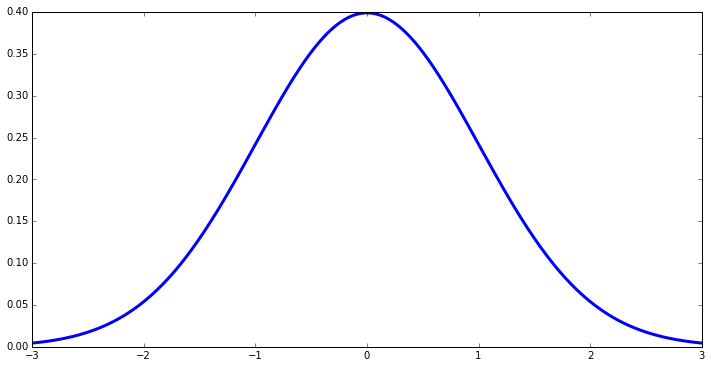

In [2176]:
xg = np.linspace(-3,3,300)
yg = 1/np.sqrt(2*np.pi)*np.exp(-1./2.*xg**2)

pyplot.figure(figsize=(12,6))
pyplot.plot(xg,yg,lw=3);

In [2183]:
n = 6
k = 16
l = 0.1
show3 = False

ValueError: 'axis' entry is out of bounds

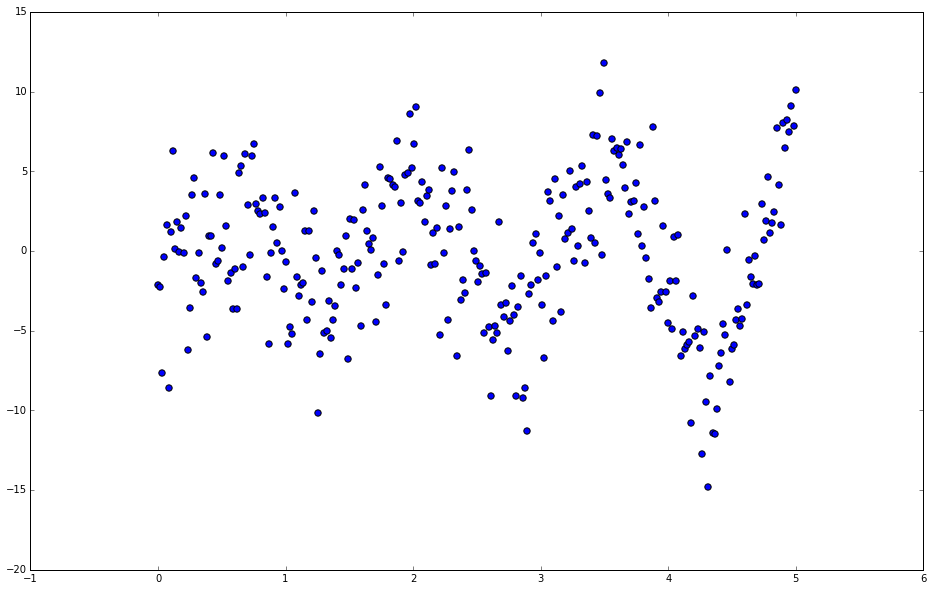

In [2184]:
pyplot.figure(figsize=(16,10))
if show3:
    pyplot.plot(x, ytrue, label="originał", lw=3)
pyplot.scatter(x,y, s=40)
if k > 0:
    predict1 = np.array([np.mean(kneighbors(k, i, x, y)) for i in t])
    pyplot.plot(t, predict1, label="k="+str(k), lw=3, color="green")
    if l > 0:
        predict2 = Kernel(D1,t,x,y,l)
        pyplot.plot(t, predict2, label="lambda=" + str(l), lw=3, color="red")
        print("RMSE: ", J(predict2,ttrue))
pyplot.xlim(0,5)
pyplot.legend();

## Dlaczego $k$-NN jest wolny?

* W zestawie MNIST, ile musimy wykonać obliczeń, żeby zaklasyfikować zestaw testowy?
* W $n$ wymiarach nie ma sposobu na przyspieszenie metody. 
* Nie znamy odległości między dwoma punktami, póki jej nie obliczymy.
* Wszystkie metody przyspieszenia są przybliżeniowe, czyli tracimy pewną cześć informacji.

## Jeśli zgodzimy się na stratę informacji

**Redukcja wymiaru $n$** 
* Przyspieszenie na poziomie jednej pary przykładów
* Ręczne selekcja cech
* Algorytmy genetyczne
* Inne metody automatyczne

**Zmiana organizacji przykładów:**
* Przyspieszenie przez ograniczenie zbioru
* Ciekawe: 
    * *Locality sensitive hashing*
    * *Clustering based search*
* Wikipedia: [Nearest Neighbor Search](https://en.wikipedia.org/wiki/Nearest_neighbor_search)